In [3]:
!pip install --user pymbar

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
     |████████████████████████████████| 100 kB 5.3 MB/s ta 0:00:011
You should consider upgrading via the '/cm/local/apps/python37/bin/python3 -m pip install --upgrade pip' command.


In [2]:
%cd /data/wesley/ETDM_log_p
!ls

/data/wesley/ETDM_log_p
Untitled.ipynb


In [22]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

import bokeh as bk
import numpy as np
from bokeh.plotting import figure, show
from bokeh.io import output_notebook

import ipywidgets as widgets
from ipywidgets import interact,interact_manual

import tqdm

output_notebook()

Loading BokehJS ...

In [6]:
class Simple_1D_BD_Sim:
    def __init__(
        self, 
        potential_gradient_function,
        parameter_dict=None, 
        starting_coordinates=0, #technically 'coordinate' since this is 1D #1D function,takes a coordinate (x) and yields grad(U(x)). I.e. dU/dx
    ):
        self.kb=0.001985875 #kcal/(mol*K)
        self.parameter_dict=dict(
            diffusionConstant=1.0, #in Å**2/(fs) -> i.e. square distance per time unit
            temperature=310.15, # Kelvins (default = normal body temperature),
            vmax=1.5, #maximum allowed velocity (violation will terminate simulation due to instability)
            trajectorySnapshotRate=100, #number of steps between saving to trajectory data
            periodicBoundaryLength=None,
            timestep=1.0, #time step in fs
            verbose=False,
        )
        if not (parameter_dict is None):
            self.set_parameters(parameter_dict)
        if not (starting_coordinates is None):
            self.x0=starting_coordinates
        else:
            self.x0=0
            
        self.set_potential_gradient_function(potential_gradient_function)
        
        
    def set_parameters(self,parameter_dict):
        for parameterName in parameter_dict:
            if parameterName in self.parameter_dict: #make sure we dont add unsupported parameters
                self.parameter_dict[parameterName]=parameter_dict[parameterName]
            elif self.parameter_dict['verbose']:
                print('Warning: parameter "%s" not supported'%(str(parameterName)))
    
    def set_potential_gradient_function(self,potential_gradient_function):
        self.potential_gradient_function=potential_gradient_function
   
    def set_x0(self,x0):
        self.x0=x0
        
    def run_sim(
        self,
        nsteps=10000,
        giveVelocities=False,
        randomSeed=None,
        pbar=None,
    ):
        
        x=self.x0
        bPBL=self.parameter_dict['periodicBoundaryLength']
        if not (bPBL is None):
            x=x%bPBL
        bD=self.parameter_dict['diffusionConstant']
        kb=self.kb
        bT=self.parameter_dict['temperature']
        trajInterval=self.parameter_dict['trajectorySnapshotRate']
        verbose=self.parameter_dict['verbose']
        bVmax=self.parameter_dict['vmax']
        ts=self.parameter_dict['timestep']
        gradUfun=self.potential_gradient_function
        print(nsteps)
        if not (randomSeed is None): #in case we want to specify a specific random seed for reproducibility
            np.random.seed(randomSeed)
        trajectoryData=np.zeros(int(nsteps/trajInterval))
        if giveVelocities:
            velocityData=np.zeros(nsteps)
        
        tStep=0    
        stable=True
        # X'(t)=-D/(kbT)*grad(U(X))+√(2D)*R(t)
        #R -> stationary gaussian process
        while (tStep<nsteps) and stable:
            v=( -bD/(kb*bT)*gradUfun(x)+np.sqrt(2*bD)*np.random.normal(scale=1/np.sqrt(ts)) )*ts
            if (tStep%trajInterval) == 0:
                trajectoryData[int(tStep/trajInterval)]=x
                if giveVelocities:
                    velocityData[int(tStep/trajInterval)]=v
            if np.abs(v)>bVmax:
                stable=False
                if verbose:
                    print(
                        ("ERROR (step %g): velocity (%.3e) exceeds maximum (%.3e),"+\
                        "simulation terminated due to instability")%(
                            tStep,v,bVmax
                        )
                    )
            if not pbar is None:
                pbar.update()
            x=x+v
            if not (bPBL is None):
                x=x%bPBL
            tStep=tStep+1
        outDict=dict(
            trajectory=trajectoryData[:(int(tStep/trajInterval)+1)]
        )
        if giveVelocities:
            outDict['velocities']=velocityData[:(int(tStep/trajInterval)+1)]
        return(outDict)

'kbT/2=3.080E-01'

/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


1000000
<v**2>/2=0.25924810 at D=0.250 fs; <|v|>=0.57509131 at timestep=1.000; total steps = 1e+06 (1.0000 ns)


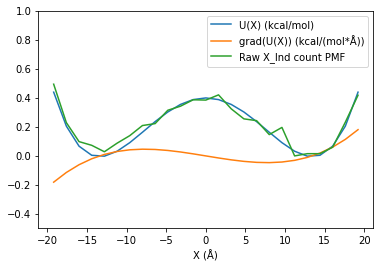

In [26]:
def potFunTest(x):
    return (1./80000.)*x**4+(.4-(.45/100)*x**2)
def potGradFunTest(x):
    return 4*(1./80000)*x**3-2*(.45/100)*x
    
diffCoef=.25
sim_dt=1.0
bd_TestSim=Simple_1D_BD_Sim(potGradFunTest)
bd_TestSim.set_parameters(dict(
    diffusionConstant=diffCoef,
    vmax=15.0,
    trajectorySnapshotRate=int(100/sim_dt),
    verbose=True,
    timestep=sim_dt
))
bd_TestSim.set_x0(0.)

display(
    'kbT/2=%.3E'%(
        bd_TestSim.parameter_dict['temperature']*bd_TestSim.kb/2.
    )
)


binEdges=np.linspace(-20,20,26)
binCenters=(binEdges[:-1]+binEdges[1:])/2.
xgrid=binCenters#np.linspace(-30,30,101)
sns.lineplot(
    x=xgrid,
    y=potFunTest(xgrid),
    label='U(X) (kcal/mol)'
)
sns.lineplot(
    x=xgrid,
    y=potGradFunTest(xgrid),
    label='grad(U(X)) (kcal/(mol*Å))'
)
plt.ylim(-.5,1.)
plt.xlabel('X (Å)')

bd_TestSim.set_x0(0.)
nsteps=int(1000000/sim_dt) #100000000
trajTestData=bd_TestSim.run_sim(
    nsteps=nsteps,
    giveVelocities=True,
    pbar=tqdm.tqdm_notebook(total=nsteps))

kb=bd_TestSim.kb
kbT=bd_TestSim.kb*bd_TestSim.parameter_dict['temperature']
dt=bd_TestSim.parameter_dict['timestep']
print(
    '<v**2>/2={hvsq:.8f} at D={D:.3f} fs'.format(
        D=bd_TestSim.parameter_dict['diffusionConstant'],
        hvsq=np.mean((trajTestData['velocities']/dt)**2/2.))+ \
    '; <|v|>={v:.8f} at timestep={ts:.3f}'.format(
        ts=bd_TestSim.parameter_dict['timestep'],
        v=np.mean(np.abs(trajTestData['velocities'])/dt))+ \
    '; total steps = {nts:g} ({simtime:.4f} ns)'.format(
        nts=nsteps, simtime=nsteps*bd_TestSim.parameter_dict['timestep']*1E-6
    )
)
xgrid=binCenters
test_pmf_hist=np.histogram(
    a=trajTestData['trajectory'],
    bins=binEdges
)
test_pmf_vec=test_pmf_hist[0]
test_pmf_vec=test_pmf_vec/np.sum(test_pmf_vec)
test_pmf_vec=-kbT*np.log(test_pmf_vec/np.max(test_pmf_vec))
sns.lineplot(
    x=xgrid,
    y=test_pmf_vec,
    label='Raw X_Ind count PMF'
)
plt.ylim(-.5,1.)
plt.show()

plt.show()


In [56]:
def gen_harmonic_window_potFun(potFun,win_center,kval):
    return(
        lambda x: potFun(x)+.5*kval*(x-win_center)**2
    )
def gen_harmonic_window_potGradFun(potGradFun,window_center,kval):
    return(
        lambda x: potGradFun(x)-kval*(window_center-x)
    )

In [47]:
windowKvals

array([0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625,
       0.015625, 0.015625, 0.015625, 0.015625, 0.015625])

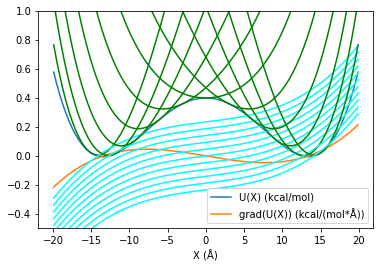

In [57]:
windowCenters=np.linspace(-15,15,11)
windowKvals=np.array([2**-6]*len(windowCenters))
window_potFuns=[
    gen_harmonic_window_potFun(potFunTest,wc,wk) \
    for wc,wk in zip(windowCenters,windowKvals)
]
window_potGradFuns=[
    gen_harmonic_window_potGradFun(potGradFunTest,wc,wk) \
    for wc,wk in zip(windowCenters,windowKvals)
]

binEdges=np.linspace(-20,20,201)
binCenters=(binEdges[:-1]+binEdges[1:])/2.
xgrid=binCenters#np.linspace(-30,30,101)
sns.lineplot(
    x=xgrid,
    y=potFunTest(xgrid),
    label='U(X) (kcal/mol)'
)
sns.lineplot(
    x=xgrid,
    y=potGradFunTest(xgrid),
    label='grad(U(X)) (kcal/(mol*Å))'
)
plt.ylim(-.5,1.)
plt.xlabel('X (Å)')

for iWin,windowCenter in enumerate(windowCenters):
    sns.lineplot(
        x=xgrid,
        y=window_potFuns[iWin](xgrid),
        #label='U(X) (kcal/mol)',
        color='green'
    )
    sns.lineplot(
        x=xgrid,
        y=window_potGradFuns[iWin](xgrid),
        #label='grad(U(X)) (kcal/(mol*Å))',
        color='cyan'
    )

/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


500000
<v**2>/2=0.25003156 at D=0.250 fs; <|v|>=0.56129798 at timestep=1.000; total steps = 500000 (0.5000 ns)


/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log
/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


500000
<v**2>/2=0.24569593 at D=0.250 fs; <|v|>=0.55779223 at timestep=1.000; total steps = 500000 (0.5000 ns)



/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log
/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


500000
<v**2>/2=0.25147153 at D=0.250 fs; <|v|>=0.56646427 at timestep=1.000; total steps = 500000 (0.5000 ns)



/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log
/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


500000
<v**2>/2=0.25433602 at D=0.250 fs; <|v|>=0.56814548 at timestep=1.000; total steps = 500000 (0.5000 ns)



/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


500000
<v**2>/2=0.25214669 at D=0.250 fs; <|v|>=0.56528496 at timestep=1.000; total steps = 500000 (0.5000 ns)


/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


500000
<v**2>/2=0.25846973 at D=0.250 fs; <|v|>=0.57228728 at timestep=1.000; total steps = 500000 (0.5000 ns)



/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


500000
<v**2>/2=0.24946119 at D=0.250 fs; <|v|>=0.56154430 at timestep=1.000; total steps = 500000 (0.5000 ns)


/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


500000
<v**2>/2=0.25338967 at D=0.250 fs; <|v|>=0.56487797 at timestep=1.000; total steps = 500000 (0.5000 ns)


/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log
/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


500000
<v**2>/2=0.25259708 at D=0.250 fs; <|v|>=0.56650021 at timestep=1.000; total steps = 500000 (0.5000 ns)



/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log
/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


500000
<v**2>/2=0.25510972 at D=0.250 fs; <|v|>=0.56849286 at timestep=1.000; total steps = 500000 (0.5000 ns)


/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log
/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


500000
<v**2>/2=0.24755389 at D=0.250 fs; <|v|>=0.55959944 at timestep=1.000; total steps = 500000 (0.5000 ns)



/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log


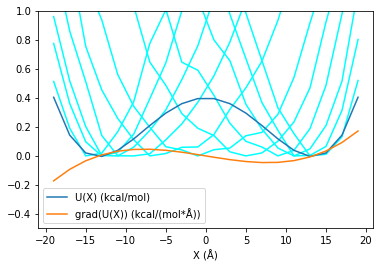

In [64]:
sim_dt=1.0 #fs
diffCoef=.25
simChemTime=.50 #ns
snapRate=100
nsteps=int(simChemTime*1E6/sim_dt)
nSnaps=int(nsteps/snapRate)

binEdges=np.linspace(-20,20,21)
binCenters=(binEdges[:-1]+binEdges[1:])/2.
window_sim_data=[np.zeros(nsteps)]*len(windowCenters)
for iWin,windowCenter in enumerate(windowCenters): #[5:6]):
    windowK=windowKvals[iWin]
    bd_TestSim=Simple_1D_BD_Sim(window_potGradFuns[iWin])
    bd_TestSim.set_parameters(dict(
        diffusionConstant=diffCoef,
        vmax=15.0,
        trajectorySnapshotRate=snapRate,
        verbose=True,
        timestep=sim_dt
    ))
    bd_TestSim.set_x0(windowCenters[iWin])
    #nsteps=int(2000000/sim_dt) #100000000
    trajTestData
    window_sim_data[iWin]=bd_TestSim.run_sim(
        nsteps=nsteps,
        giveVelocities=True,
        pbar=tqdm.tqdm_notebook(total=nsteps))

    trajTestData=window_sim_data[iWin]
    kb=bd_TestSim.kb
    dt=bd_TestSim.parameter_dict['timestep']
    print(
        '<v**2>/2={hvsq:.8f} at D={D:.3f} fs'.format(
            D=bd_TestSim.parameter_dict['diffusionConstant'],
            hvsq=np.mean((trajTestData['velocities']/dt)**2/2.))+ \
        '; <|v|>={v:.8f} at timestep={ts:.3f}'.format(
            ts=bd_TestSim.parameter_dict['timestep'],
            v=np.mean(np.abs(trajTestData['velocities'])/dt))+ \
        '; total steps = {nts:g} ({simtime:.4f} ns)'.format(
            nts=nsteps, simtime=nsteps*bd_TestSim.parameter_dict['timestep']*1E-6
        )
    )
    xgrid=binCenters
    test_pmf_hist=np.histogram(
        a=trajTestData['trajectory'],
        bins=binEdges
    )
    test_pmf_vec=test_pmf_hist[0]
    test_pmf_vec=test_pmf_vec/np.sum(test_pmf_vec)
    test_pmf_vec=-kbT*np.log(test_pmf_vec/np.max(test_pmf_vec))
    test_pmf_vec[np.where(np.isfinite(test_pmf_vec)==False)]
    sns.lineplot(
        x=xgrid,
        y=test_pmf_vec,
        #label='Raw X_Ind count PMF',
        color='cyan'
    )
    plt.ylim(-.5,1.)
    #plt.show()

xgrid=binCenters#np.linspace(-30,30,101)
sns.lineplot(
    x=xgrid,
    y=potFunTest(xgrid),
    label='U(X) (kcal/mol)'
)
sns.lineplot(
    x=xgrid,
    y=potGradFunTest(xgrid),
    label='grad(U(X)) (kcal/(mol*Å))'
)
plt.ylim(-.5,1.)
plt.xlabel('X (Å)')
plt.show()

In [ ]:

binEdges=np.linspace(-25,25,26)
binCenters=(binEdges[:-1]+binEdges[1:])/2.
for sim_dt in [1.]:
    for sim_D in [.03125,.0625,.125,.25]:#,.0625,.125,.25,.5,1.]:
        diffCoef=sim_D
        bd_TestSim=Simple_1D_BD_Sim(potGradFunTest)
        bd_TestSim.set_parameters(dict(
            diffusionConstant=diffCoef,
            vmax=15.0,
            trajectorySnapshotRate=int(100/sim_dt),
            verbose=True,
            timestep=sim_dt
        ))
        bd_TestSim.set_x0(0.)
        nsteps=int(2000000/sim_dt) #100000000
        trajTestData=bd_TestSim.run_sim(
            nsteps=nsteps,
            giveVelocities=True,
            pbar=tqdm.tqdm_notebook(total=nsteps))

        kb=bd_TestSim.kb
        dt=bd_TestSim.parameter_dict['timestep']
        print(
            '<v**2>/2={hvsq:.8f} at D={D:.3f} fs'.format(
                D=bd_TestSim.parameter_dict['diffusionConstant'],
                hvsq=np.mean((trajTestData['velocities']/dt)**2/2.))+ \
            '; <|v|>={v:.8f} at timestep={ts:.3f}'.format(
                ts=bd_TestSim.parameter_dict['timestep'],
                v=np.mean(np.abs(trajTestData['velocities'])/dt))+ \
            '; total steps = {nts:g} ({simtime:.4f} ns)'.format(
                nts=nsteps, simtime=nsteps*bd_TestSim.parameter_dict['timestep']*1E-6
            )
        )
        xgrid=binCenters
        test_pmf_hist=np.histogram(
            a=trajTestData['trajectory'],
            bins=binEdges
        )
        test_pmf_vec=test_pmf_hist[0]
        test_pmf_vec=test_pmf_vec/np.sum(test_pmf_vec)
        test_pmf_vec=-kbT*np.log(test_pmf_vec/np.max(test_pmf_vec))
        sns.lineplot(
            x=xgrid,
            y=test_pmf_vec,
            label='Raw X_Ind count PMF'
        )
        plt.ylim(-.5,1.)
        plt.show()

        xgrid=binCenters#np.linspace(-30,30,101)
        sns.lineplot(
            x=xgrid,
            y=potFunTest(xgrid),
            label='U(X) (kcal/mol)'
        )
        sns.lineplot(
            x=xgrid,
            y=potGradFunTest(xgrid),
            label='grad(U(X)) (kcal/(mol*Å))'
        )
        plt.ylim(-.5,1.)
        plt.xlabel('X (Å)')
        plt.show()